IMPORTS

In [3]:
import numpy as np
import pandas as pd
import tensorflow as tf
from matplotlib import pyplot as plt
np.set_printoptions(precision=3, linewidth=2*75, suppress=False)
from IPython.display import clear_output
from rise_and_fall import *
from dataset import Dataset
import json
import time
from neural_network import *

PLOT FUNTIONS

In [ ]:
def plot_frame(f:pd.DataFrame, mxis=[], mnis=[], mark=None):
    ps = f["meanp"].to_numpy()
    mn = ps.min()
    mx = ps.max()
    plt.plot(ps)
    if len(mxis)>0:
        plt.vlines(x = mxis, ymin = mn, ymax = mx, colors = 'green',)
    elif 'mxis' in f.columns:
        plt.vlines(x = f.index[f['mxis']>0], ymin = mn, ymax = mx, colors = 'green',)
    if len(mnis)>0:
        plt.vlines(x = mnis, ymin = mn, ymax = mx, colors = 'red',)
    elif 'mnis' in f.columns:
        plt.vlines(x = f.index[f['mnis']>0], ymin = mn, ymax = mx, colors = 'red',)
    if mark is not None:
        plt.vlines(x = [mark], ymin = mn, ymax = mx, colors = 'blue',)
    plt.show()
    
def unique(xs):
    ys = []
    for x in xs:
        if x in ys:
            continue
        ys.append(x)
    return ys

SAVING DATASETS IN NPY

In [ ]:
# db = Dataset()
# if __name__=='__main__':
#     inputs, outputs = db.get_data_set(
#             batch_size=2**16, max_procs=10, single_process_size=2**10, buy=True, validation=False, test=False)
# if __name__=='__main__':
#     vlx, vly = db.get_data_set(
#             batch_size=2**13, max_procs=10, single_process_size=2**10, buy=True, validation=True, test=False)
# if __name__=='__main__':
#     lrx, lry = db.get_data_set(
#             batch_size=2**12, max_procs=10, single_process_size=2**9, buy=True, validation=False, test=False)
# np.save('database/inputs.npy', inputs)
# np.save('database/outputs.npy', outputs)

# np.save('database/vlx.npy', vlx)
# np.save('database/vly.npy', vly)

# np.save('database/lrx.npy', lrx)
# np.save('database/lry.npy', lry)

RETRIVING DATASET

In [5]:
dsx_name = 'vlx'
dsy_name = 'vly'

ds = np.load(f'database/{dsx_name}.npy', mmap_mode='r')
indicies = np.random.choice(ds.shape[0], (2**10,))
x = ds[indicies]
del ds
print(x.shape)

ds = np.load(f'database/{dsy_name}.npy', mmap_mode='r')
y = ds.T[indicies]
y=y.T
del ds
print(y.shape)

(1024, 288, 12)
(3, 1024)


MODEL TESTING

53983093 selected
Retrived Trained Model
32/32 [==============================] - 1s 17ms/step


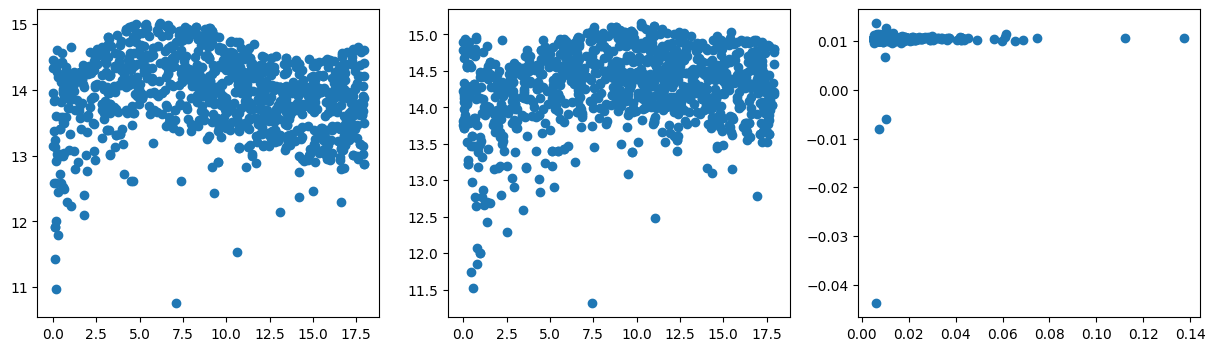

In [7]:
model = get_bp_model(3e-4)
yp = model.predict(x)
ya = [y[i] for i in range(y.shape[0])]
plt.figure(figsize=(15,4))
for i in range(y.shape[0]):
    plt.subplot(1,3,i+1)
    plt.scatter(ya[i], yp[i])

RANDOM

In [4]:
model = get_bp_model(1e-3)
model.summary()

53983093 selected
Retrived Trained Model
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 288, 12)]    0           []                               
                                                                                                  
 bidirectional (Bidirectional)  (None, 128)          29952       ['input_1[0][0]']                
                                                                                                  
 dense (Dense)                  (None, 128)          16512       ['bidirectional[0][0]']          
                                                                                                  
 dropout (Dropout)              (None, 128)          0           ['dense[0][0]']                  
                                                     

In [ ]:
with open("datasplit.json", 'r') as file:
        dataset = json.load(file)

In [ ]:
db = Dataset()

In [ ]:
aa = []
size = 0
look_past = 0
while size<32:
    a,b,c,d = db.labeled_buy_frame(at=100000-look_past, length=288, to_numpy=False)
    ai = a.loc[np.logical_or(a['mnis']==1, a['mxis']==1), :]
    temp_a = np.zeros((ai.shape[0], 7))
    for i in range(1, ai.index.shape[0]):
        temp_a[i, 0:4] = a.loc[ai.index[i-1]:ai.index[i-1], ['meanp', 'ch', 'taker', 'maker']].mean().to_numpy().flatten()
        temp_a[i, 4:6] = a.loc[ai.index[i-1]:ai.index[i-1], ['vol', 'ntrds']].sum().to_numpy().flatten()
        temp_a[i, 6] = a.loc[ai.index[i-1]:ai.index[i-1], 'meanp'].std()
    
    # temp_a =pd.DataFrame(temp_a, columns=['meanpp', 'chp', 'takerp', 'makerp','vols', 'ntrdss', 'meanpsstd'])
    # ai.reset_index(drop=True, inplace=True)
    # pd.concat([ai, temp_a], axis=1)
    break
#     aa.append(a)
#     size += a.shape[0]
#     look_past+=288
# aa.reverse()
# a = pd.concat(aa)
# a=a.iloc[-32:]
# a.reset_index(drop=True, inplace=True)
# day = a.pop('day')
# a['stime'] = a['stime']+day*18.0


In [ ]:
a,b,c,d = db.labeled_buy_frame(at=100000-look_past, length=288, to_numpy=False)

In [ ]:
mu = a.to_numpy().mean()
sigma = a.to_numpy().std()
(a-mu)/sigma

In [ ]:
ai.index

In [ ]:
a.loc[6:10, 'meanp'].std()

In [ ]:
a

In [ ]:
plot_frame(a)

In [ ]:
# initial_learning_rate = 0.005
# decay_rate=0.87
# decay_steps=1024*5
# y = lambda step: initial_learning_rate * (decay_rate ** (np.round(step / decay_steps, 0)))

# steps = np.array([i for i in range(int(100*1024))])
# plt.semilogy(steps, y(steps))
# print(y(steps)[-1])

In [ ]:
print(get_bp_model(1).summary())
lrs = lambda epoch: 1e-4 * 10**(epoch/20)
lr_scheduler = tf.keras.callbacks.LearningRateScheduler(lrs)
history = train_bp_model(inputs=x, outputs=[y[i] for i in range(y.shape[0])], epochs=60, verbose=0, save=False, patience=20, mini_batch_size=128)
losses = history.history['loss']
epochs = np.array([i for i in range(len(losses))])
plt.semilogx(lrs(epochs), history.history['loss'])

In [ ]:
lrs(epochs)[np.argmin(losses)]

In [ ]:
lambda step: initial_learning_rate * (decay_rate ** (np.round(step / decay_steps, 0)))

In [ ]:
plt.plot(np.array([i*np.log(i+1) for i in range(100)]))

In [ ]:
y=0.1
ys = []
for i in range(100):
    ys.append(y)
    # y = y*0.97**(i**2.6/(i+1)**2.4)
    y = 0.05*0.9**(12*np.log(i+1))
print(ys[-1])
plt.plot(ys)

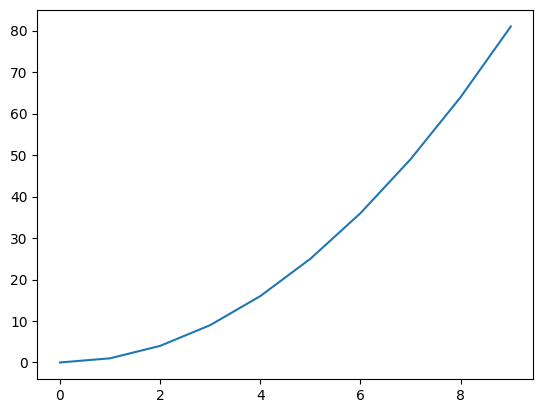

In [5]:
plt.plot([i**2.0 for i in range(10)])

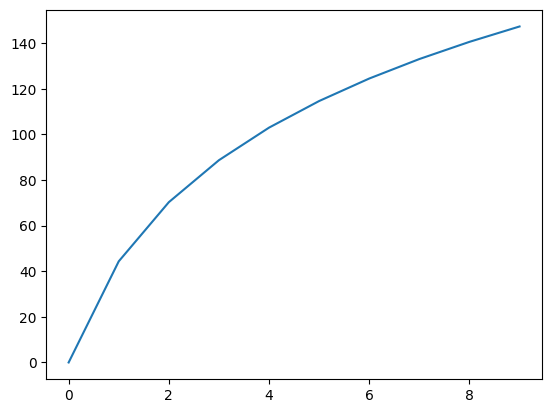

In [3]:
plt.plot([64*np.log(i+1) for i in range(10)])

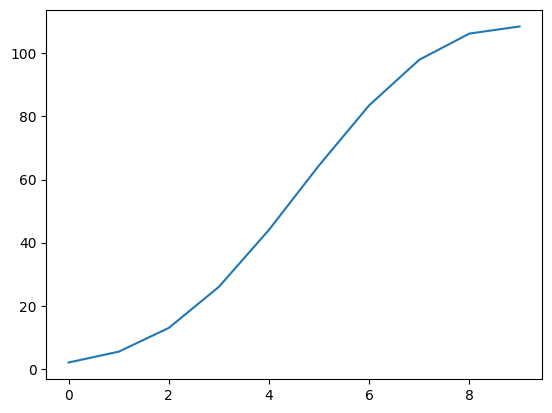

In [4]:
plt.plot([2*np.exp(i**(0.95**i)) for i in range(10)])

In [ ]:
[i*18.0 for i in range(7)]